In [1]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import pandas as pd
from utils import simulate_bagging_and_variance, save_results_png, save_result_csv
import pandas as pd
import os

Simulations: 100%|██████████| 2000/2000 [03:45<00:00,  8.87simulation/s]
c:\Users\rehan\meine_Repos\Masterarbeit\Chapter 2\Figure_2.11\utils.py:240: RuntimeWarning: invalid value encountered in sqrt
  unbiased_std_estimate = (est_vars_biased - bias_correction) ** 0.5


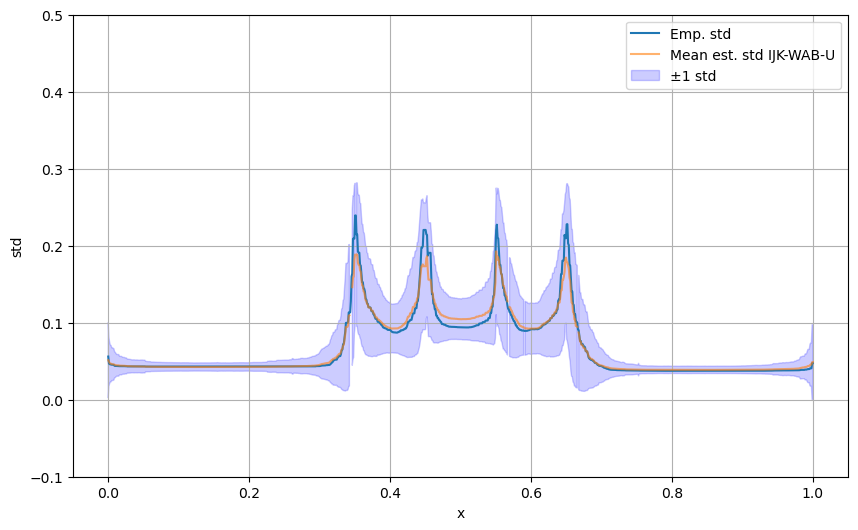

In [2]:
for p in [x/10 for x in range(5,6) ]:
    ####### Simulation parameters  #####################
    portion_non_zero_weights = p
    n_sim = 2_000
    args = {"max_leaf_nodes": 5}
    seed = 42

    # make sure there are round about 500 data points
    n = int(500/portion_non_zero_weights)
    m = int(n * portion_non_zero_weights)
    B = n

    ####### sim description ############################
    text = f"mit emp std für Konfidenzintervall\nmit weighted Bootstrap\nmit {portion_non_zero_weights*100}% non-zero weights\n"
    folder_name = f"figure2_wager_weighted_{portion_non_zero_weights}_"

    def make_folder(m,text,folder_name):
        folder_name2 = folder_name + "_nx" + str(m)
        if not os.path.exists("./figures/" + folder_name2):
            os.makedirs("./figures/" + folder_name2)
        with open("./figures/" + folder_name2 + "/readme.txt", "w") as f:
            f.write(text)
            
    make_folder(m,text,folder_name)

    # data and weights for X
    x_fix = np.linspace(0, 1, n)
    new_data = np.linspace(0, 1, n)

    rng = np.random.default_rng(seed)
    weights = np.zeros(n)
    weights += 1 / m
    index_drop = rng.choice(range(n), size=n - m, replace=False)
    weights[index_drop] = 0.0


    # run simulations
    with ProcessPoolExecutor(max_workers=10) as executor:
        
        bagged_preds = np.zeros((n_sim, new_data.shape[0]))
        biased_var_estimates = np.zeros((n_sim, new_data.shape[0]))
        bias_corrections = np.zeros((n_sim, new_data.shape[0]))
        
        futures = [
            executor.submit(
                simulate_bagging_and_variance,
                x1=x_fix,
                B=B,
                new_data=new_data,
                simulation_index=i,
                seed=seed,
                dt_args=args,
                weights=weights,
                m=m,
            )
            for i in range(n_sim)
        ]

        for i, future in enumerate(tqdm(futures, desc="Simulations", unit="simulation")):
            bagged_prediction, biased_var_estimate, bias_correction = future.result()
            bagged_preds[i, :] = bagged_prediction
            biased_var_estimates[i, :] = biased_var_estimate
            bias_corrections[i, :] = bias_correction

    # save results
    save_result_csv(
        seed=seed,
        B=B,
        args=args,
        bagged_preds=bagged_preds,
        est_vars_biased=biased_var_estimates,
        bias_correction=bias_corrections,
        new_data=new_data,
        folder_name=folder_name + f"_nx{m}",
    )


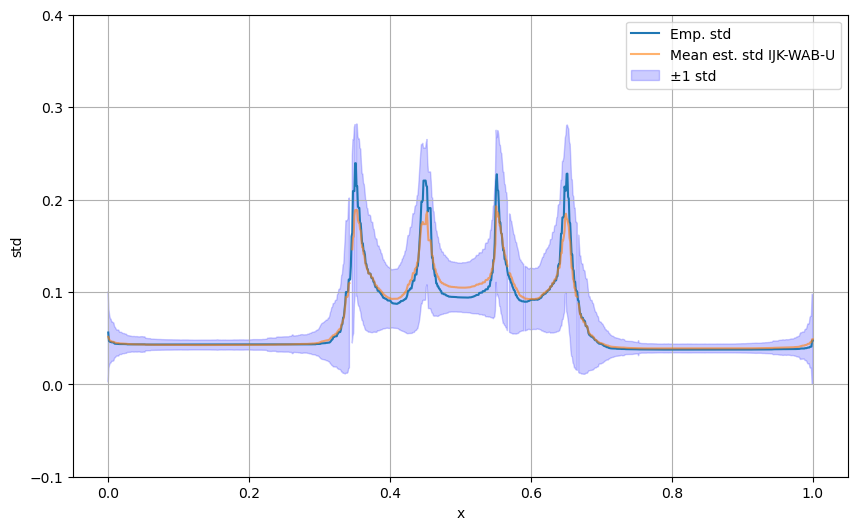

In [3]:

save_results_png(
    new_data=new_data,
    bagged_preds=bagged_preds,
    est_vars_biased=biased_var_estimates,
    bias_correction=bias_corrections,
    folder_name=folder_name + f"_nx{m}",
    n_data_points=n,
    B=B,
    seed=seed,
    dt_args=args,
    m=m,
    y_lim=[-0.1,0.4]
)